This notebook does not prep the data. Train/val/test split is very unbalanced.

## Task: Prior to starting, transfer function to a python file so they can be imported and take up less real estate.

In [1]:
#Imports
import numpy as np
import pandas as pd
import os
import shutil
import glob
import itertools
import random
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner
from keras_tuner import RandomSearch, GridSearch
from sklearn.metrics import confusion_matrix, accuracy_score
from PIL import Image

C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorflow\python\framework

C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\miniconda3\envs\tf\lib\site-packages\tensor

In [2]:
#Preferences
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [3]:
#Path variables
train_path = "data/train/"
val_path = "data/val/"
test_path = "data/test/"

In [4]:
path_list = [train_path, val_path, test_path]

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = datagen.flow_from_directory(directory=train_path,
                                              target_size=(256,256),
                                              batch_size=16,
                                              color_mode="rgb",
                                              classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                              save_format="jpeg")

Found 4332 images belonging to 3 classes.


In [7]:
val_generator = datagen.flow_from_directory(directory=val_path,
                                            target_size=(256,256),
                                            batch_size=16,
                                            color_mode="rgb",
                                            classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                            save_format="jpeg")

Found 900 images belonging to 3 classes.


In [8]:
test_generator = datagen.flow_from_directory(directory=test_path,
                                             target_size=(256,256),
                                             batch_size=16,
                                             color_mode="rgb",
                                             classes=["NORMAL", "viral_pneumonia", "bacterial_pneumonia"],
                                             save_format="jpeg",
                                             shuffle=False)

Found 624 images belonging to 3 classes.


### Transfer learning

In [ ]:
keras.applications.

In [9]:
earlystop = EarlyStopping(monitor="val_loss", patience = 4)

In [10]:
list_of_models = ["DenseNet121", "DenseNet169", "DenseNet201", "InceptionResNetV2", "InceptionV3", "MobileNet", "MobileNetV2", "ResNet50", "Vgg16", "Vgg19", "Xception"]

In [17]:
#inception_resnet_v2 and inception_v3 threw an error so I'm trying the rest
shorter_list = ["MobileNet", "MobileNetV2", "ResNet50", "vgg16", "Xception"]

In [13]:
train_generator.reset()
val_generator.reset()
test_generator.reset()

In [11]:
model_metrics = []

In [18]:
for app_model in shorter_list:
    base_model = getattr(keras.applications, app_model)(
    weights="imagenet",
    input_shape=(256,256,3),
    include_top=False)
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(256,256,3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(3)(x)
    model = keras.Model(inputs, outputs)
    
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[keras.metrics.CategoricalAccuracy()])

    history = model.fit(train_generator, epochs=5, validation_data=val_generator)
    
    model_accuracy = history.history["categorical_accuracy"]
    model_val_accuracy = history.history["val_categorical_accuracy"]
    predictions = model.predict(x=test_generator, verbose=0)
    temp_dict = {"model":app_model,
                 "train_acc":model_accuracy,
                 "val_acc":model_val_accuracy,
                 "test_preds": predictions}
    model_metrics.append(temp_dict)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()

C:\ProgramData\miniconda3\envs\tf\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/5
271/271 [==============================] - 131s 482ms/step - loss: 0.6176 - categorical_accuracy: 0.7408 - val_loss: 0.5239 - val_categorical_accuracy: 0.7633
Epoch 2/5
271/271 [==============================] - 114s 422ms/step - loss: 0.4762 - categorical_accuracy: 0.7950 - val_loss: 0.4793 - val_categorical_accuracy: 0.7733
Epoch 3/5
271/271 [==============================] - 114s 421ms/step - loss: 0.4416 - categorical_accuracy: 0.8091 - val_loss: 0.4939 - val_categorical_accuracy: 0.7789
Epoch 4/5
271/271 [==============================] - 113s 418ms/step - loss: 0.4255 - categorical_accuracy: 0.8153 - val_loss: 0.5727 - val_categorical_accuracy: 0.7400
Epoch 5/5
271/271 [==============================] - 114s 421ms/step - loss: 0.4109 - categorical_accuracy: 0.8186 - val_loss: 0.5128 - val_categorical_accuracy: 0.7711


C:\ProgramData\miniconda3\envs\tf\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/5
271/271 [==============================] - 133s 491ms/step - loss: 0.6145 - categorical_accuracy: 0.7336 - val_loss: 0.5630 - val_categorical_accuracy: 0.7511
Epoch 2/5
271/271 [==============================] - 125s 462ms/step - loss: 0.4746 - categorical_accuracy: 0.7985 - val_loss: 0.6166 - val_categorical_accuracy: 0.7189
Epoch 3/5
271/271 [==============================] - 126s 464ms/step - loss: 0.4440 - categorical_accuracy: 0.8082 - val_loss: 0.5126 - val_categorical_accuracy: 0.7800
Epoch 4/5
271/271 [==============================] - 125s 462ms/step - loss: 0.4276 - categorical_accuracy: 0.8190 - val_loss: 0.5000 - val_categorical_accuracy: 0.7844
Epoch 5/5
271/271 [==============================] - 123s 452ms/step - loss: 0.4054 - categorical_accuracy: 0.8266 - val_loss: 0.4878 - val_categorical_accuracy: 0.7867


C:\ProgramData\miniconda3\envs\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step
Epoch 1/5
271/271 [==============================] - 406s 1s/step - loss: 1.0194 - categorical_accuracy: 0.5136 - val_loss: 1.0858 - val_categorical_accuracy: 0.3478
Epoch 2/5
271/271 [==============================] - 397s 1s/step - loss: 0.9472 - categorical_accuracy: 0.5591 - val_loss: 1.0455 - val_categorical_accuracy: 0.3944
Epoch 3/5
271/271 [==============================] - 396s 1s/step - loss: 0.9206 - categorical_accuracy: 0.5856 - val_loss: 1.0088 - val_categorical_accuracy: 0.4389
Epoch 4/5
271/271 [==============================] - 396s 1s/step - loss: 0.8920 - categorical_accuracy: 0.5921 - val_loss: 0.9608 - val_categorical_accuracy: 0.4622
Epoch 5/5
271/271 [==============================] - 395s 1s/step - loss: 0.8774 - categorical_accuracy: 0.5970 - val_loss: 0.9541 - val_categorical_accuracy: 0.4933


TypeError: 'DeprecationWrapper' object is not callable

In [19]:
def plot_model_metrics(model_metrics, test_generator):
    plt.figure(figsize=(15, 8))
    
    for data in model_metrics:
        plt.plot(data["train_acc"], label=f'{data["model"]} Train Acc')
        plt.plot(data["val_acc"], label=f'{data["model"]} Val Acc')
        
        # Compute test accuracy using the predictions
        y_pred = np.argmax(data["test_preds"], axis=1)
        y_true = test_generator.classes
        test_acc = accuracy_score(y_true, y_pred)
        print(f"{data['model']} Test Accuracy: {test_acc * 100:.2f}%")
        
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

DenseNet121 Test Accuracy: 77.72%
DenseNet169 Test Accuracy: 69.07%
DenseNet201 Test Accuracy: 77.08%
MobileNet Test Accuracy: 72.92%
MobileNetV2 Test Accuracy: 77.24%
ResNet50 Test Accuracy: 48.56%


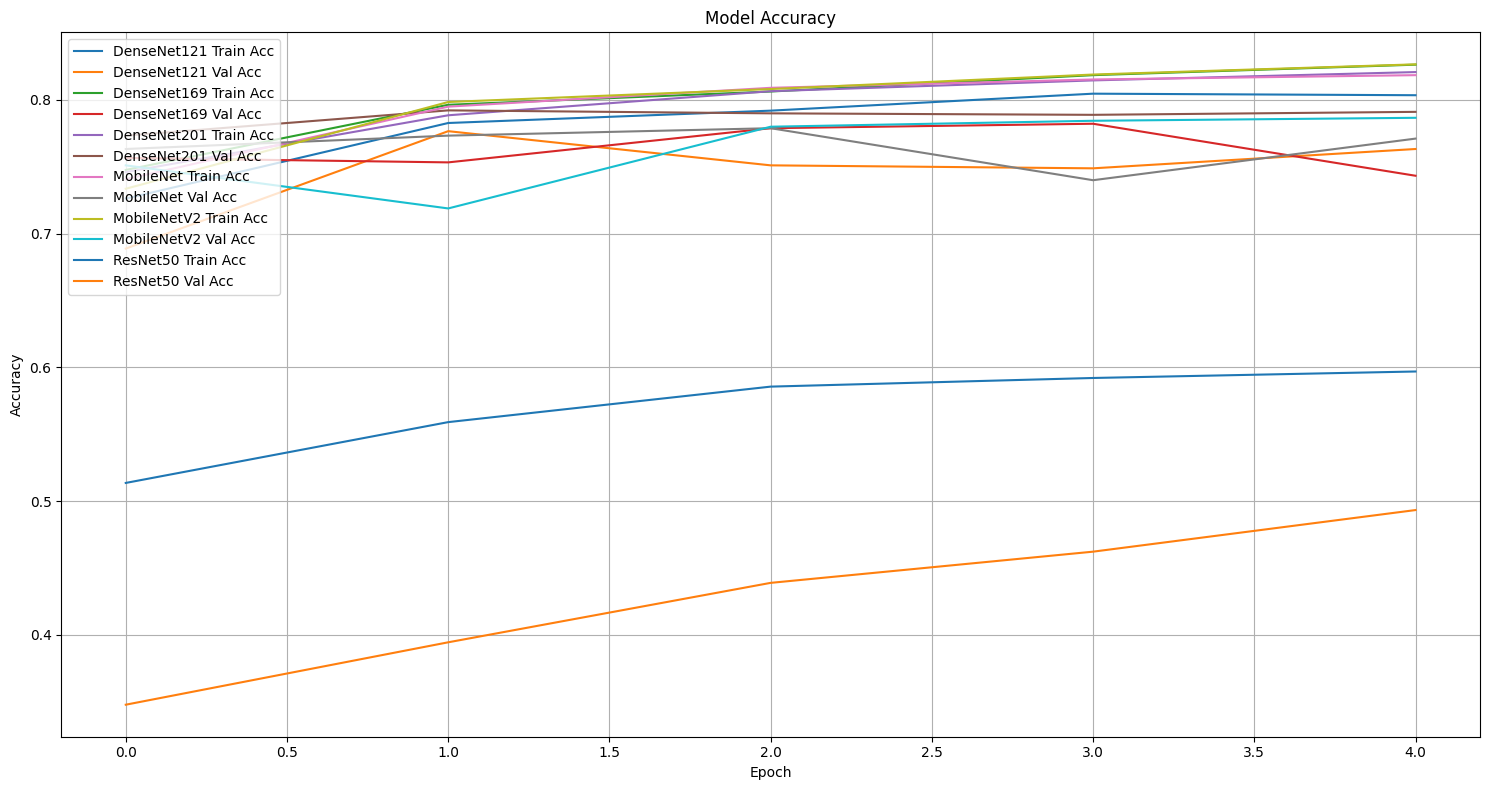

In [20]:
plot_model_metrics(model_metrics, test_generator)